### Basic Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
df = pd.read_csv('/Users/eduardo/Desktop/AssetPricing/data.csv')
print(df.head())
print(df.describe())
print(df.columns)

                                  KEY FREQ REF_AREA CURRENCY PROVIDER_FM  \
0  YC.B.U2.EUR.4F.G_N_A.SV_C_YM.BETA0    B       U2      EUR          4F   
1  YC.B.U2.EUR.4F.G_N_A.SV_C_YM.BETA0    B       U2      EUR          4F   
2  YC.B.U2.EUR.4F.G_N_A.SV_C_YM.BETA0    B       U2      EUR          4F   
3  YC.B.U2.EUR.4F.G_N_A.SV_C_YM.BETA0    B       U2      EUR          4F   
4  YC.B.U2.EUR.4F.G_N_A.SV_C_YM.BETA0    B       U2      EUR          4F   

  INSTRUMENT_FM PROVIDER_FM_ID DATA_TYPE_FM TIME_PERIOD  OBS_VALUE  ...  \
0         G_N_A        SV_C_YM        BETA0  2004-09-06   5.410510  ...   
1         G_N_A        SV_C_YM        BETA0  2004-09-07   5.391886  ...   
2         G_N_A        SV_C_YM        BETA0  2004-09-08   5.385978  ...   
3         G_N_A        SV_C_YM        BETA0  2004-09-09   5.377333  ...   
4         G_N_A        SV_C_YM        BETA0  2004-09-10   5.355732  ...   

  UNIT_INDEX_BASE                                        COMPILATION  \
0             NaN  T

### Convert `df` from long to wide and keep useful columns

In [15]:
# Parse dates
df["TIME_PERIOD"] = pd.to_datetime(df["TIME_PERIOD"])

# Keep only euro area government bond Svensson params (this matches your sample)
mask = (
    (df["REF_AREA"] == "U2") &          # euro area
    (df["CURRENCY"] == "EUR") &
    (df["PROVIDER_FM"] == "4F") &
    (df["INSTRUMENT_FM"] == "G_N_A") &
    (df["PROVIDER_FM_ID"] == "SV_C_YM")
)

df_yc = df.loc[mask, ["TIME_PERIOD", "DATA_TYPE_FM", "OBS_VALUE"]].copy()

# Pivot: rows = date, columns = parameter (BETA0, BETA1, BETA2, BETA3, TAU1, TAU2, etc.)
yc_params = df_yc.pivot_table(
    index="TIME_PERIOD",
    columns="DATA_TYPE_FM",
    values="OBS_VALUE"
).sort_index()

# Optional: keep only the main Svensson parameters if you want
needed_cols = ["BETA0", "BETA1", "BETA2", "BETA3", "TAU1", "TAU2"]
yc_params = yc_params[needed_cols]

yc_params.head()

DATA_TYPE_FM,BETA0,BETA1,BETA2,BETA3,TAU1,TAU2
TIME_PERIOD,,,,,,
2004-09-06,5.410510,-3.462358,-0.361335,-0.466368,3.128331,1.489535
2004-09-07,5.391886,-3.450353,-0.372908,-0.271295,3.157868,1.548566
2004-09-08,5.385978,-3.447950,-0.346505,-0.198077,3.137857,1.553148
2004-09-09,5.377333,-3.432592,-0.382208,-0.293482,3.271392,1.521143
2004-09-10,5.355732,-3.395283,-0.375382,-0.507894,3.279876,1.479197


### Implement Svensson formula & compute yields

In [16]:
# maturities in yrs
maturities = np.array([0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 30.0])

# make sure params are floats
params = yc_params[["BETA0", "BETA1", "BETA2", "BETA3", "TAU1", "TAU2"]].astype(float)
b0 = params["BETA0"].values
b1 = params["BETA1"].values
b2 = params["BETA2"].values
b3 = params["BETA3"].values
t1 = params["TAU1"].values
t2 = params["TAU2"].values

def svensson_spot_rate(T, beta0, beta1, beta2, beta3, tau1, tau2):

    x1 = T / tau1
    x2 = T / tau2

    # avoid division by zero
    x1 = np.where(x1 == 0, 1e-6, x1)
    x2 = np.where(x2 == 0, 1e-6, x2)

    term1 = (1.0 - np.exp(-x1)) / x1
    term2 = term1 - np.exp(-x1)
    term3 = (1.0 - np.exp(-x2)) / x2 - np.exp(-x2)

    return beta0 + beta1 * term1 + beta2 * term2 + beta3 * term3

# build yc df: rows = dates, columns = maturities
yc_yields = pd.DataFrame(index=yc_params.index)

for T in maturities:
    yc_yields[f"y_{T}y"] = svensson_spot_rate(T, b0, b1, b2, b3, t1, t2)

### Plot each maturity evelution

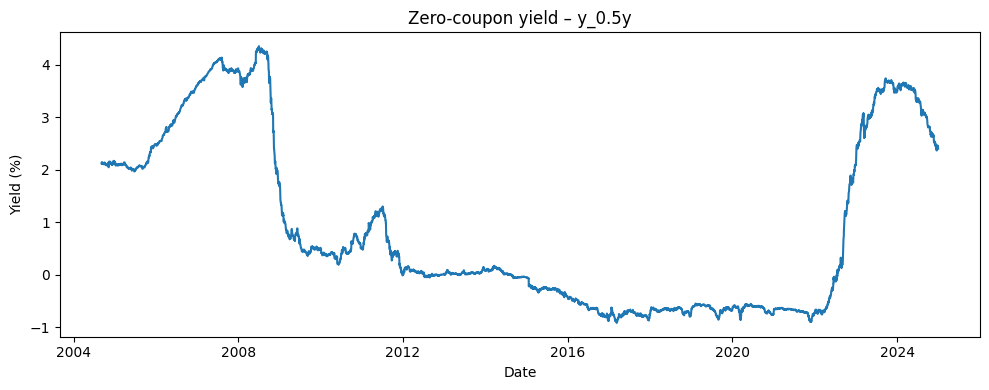

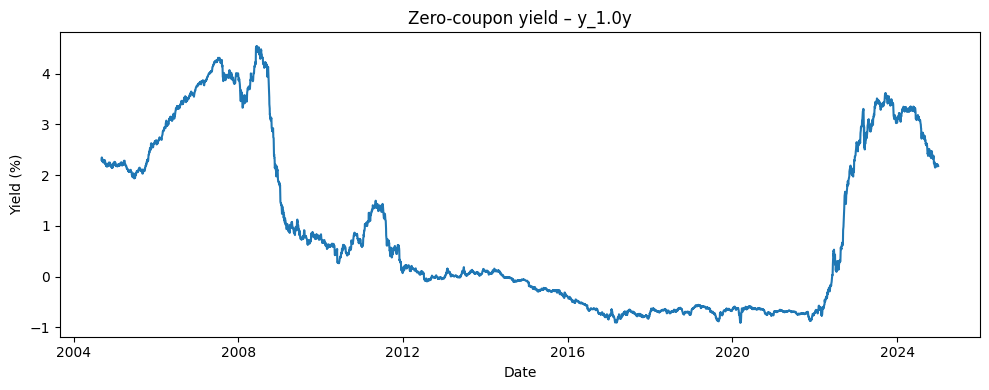

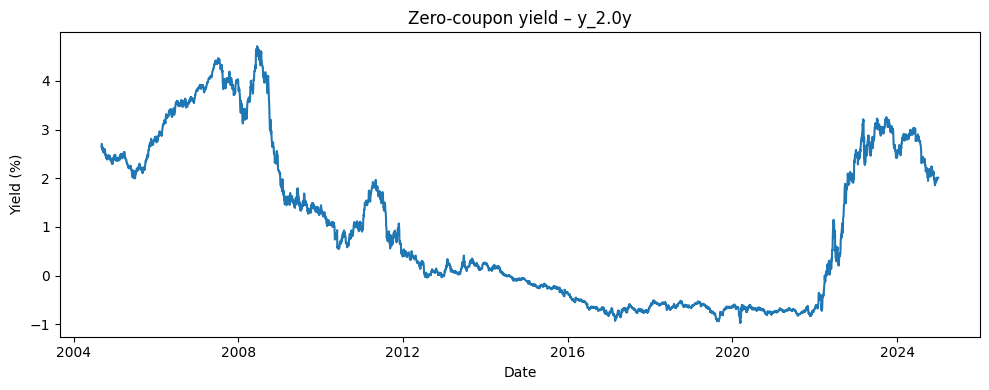

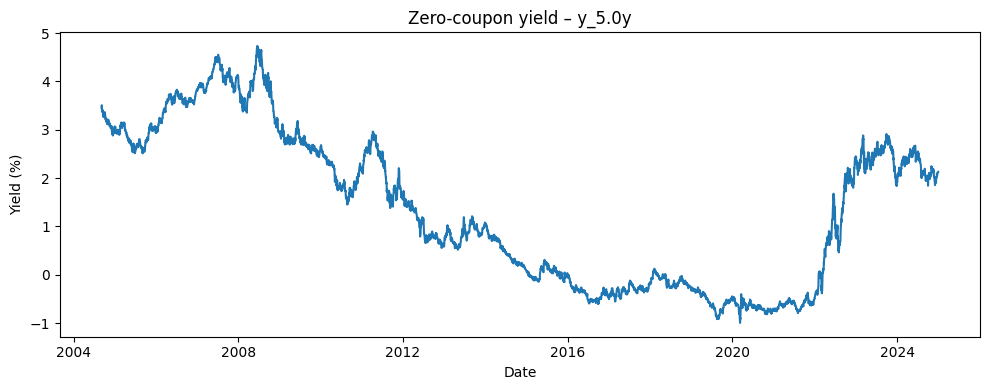

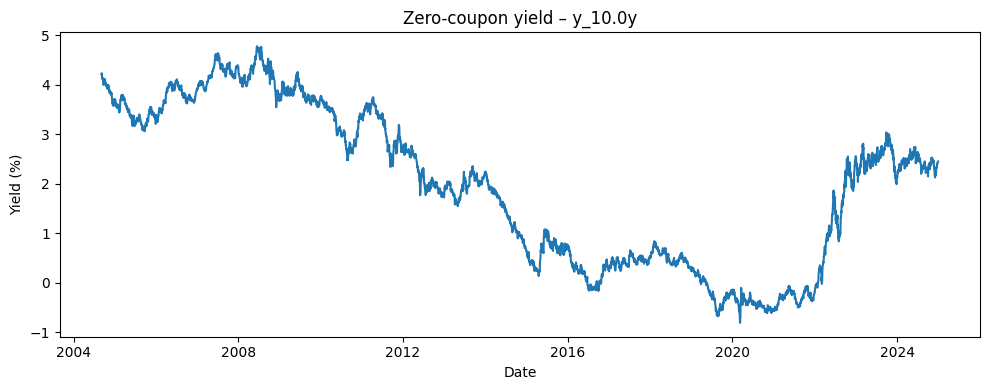

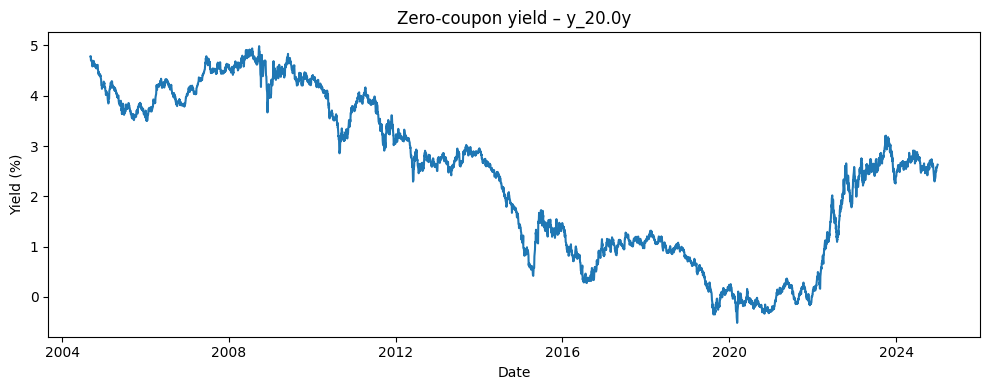

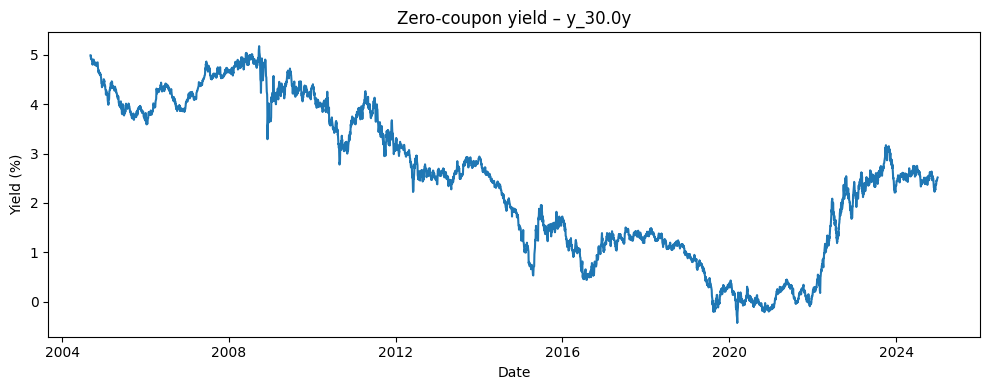

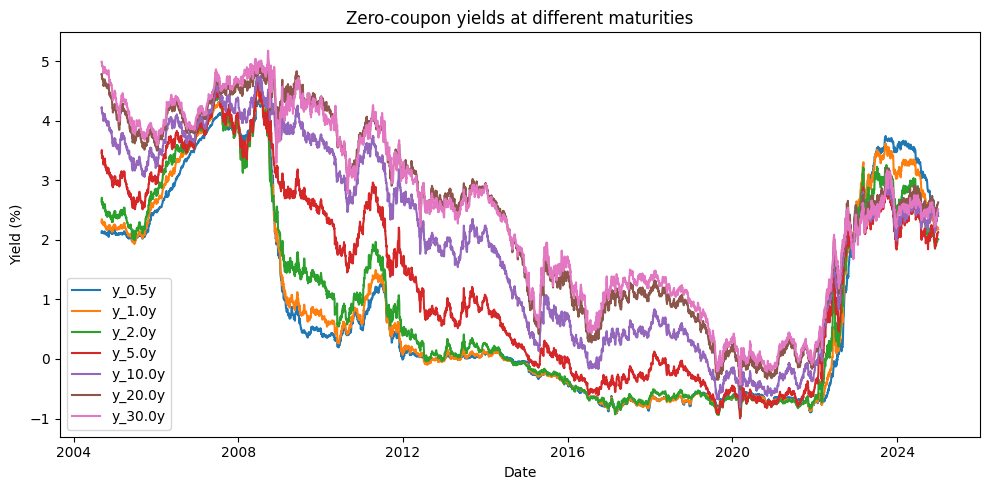

In [17]:
# A 2D plot for each maturity
for col in yc_yields.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(yc_yields.index, yc_yields[col])
    plt.title(f"Zero-coupon yield – {col}")
    plt.xlabel("Date")
    plt.ylabel("Yield (%)")
    plt.tight_layout()
    plt.show()

# 2) One 2D plot with ALL maturities together
plt.figure(figsize=(10, 5))
for col in yc_yields.columns:
    plt.plot(yc_yields.index, yc_yields[col], label=col)

plt.title("Zero-coupon yields at different maturities")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.legend()
plt.tight_layout()
plt.show()



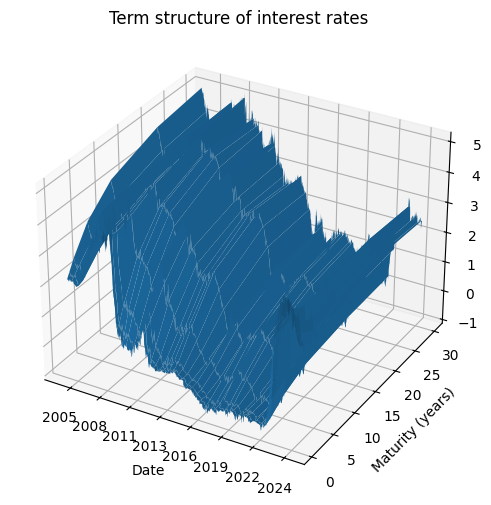

In [18]:
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plots
import matplotlib.dates as mdates

# Convert dates to numbers for plotting
dates_num = mdates.date2num(yc_yields.index.to_pydatetime())

# Extract maturities from column names like "y_10.0y"
maturities = np.array([float(c.split("_")[1].replace("y", "")) for c in yc_yields.columns])

# Create grid: X = time, Y = maturity
X, Y = np.meshgrid(dates_num, maturities)

# Z = yields (transpose to match shapes: maturities × dates)
Z = yc_yields.values.T  # shape (n_maturities, n_dates)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=True)

ax.set_xlabel("Date")
ax.set_ylabel("Maturity (years)")
ax.set_zlabel("Yield (%)")
ax.set_title("Term structure of interest rates ")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()


In [19]:
# 10-year annual coupon bond
nominal = 100.0
coupon_rate = 0.03      # 3% per year
T = 10                  # maturity in years
payment_times = np.arange(1, T + 1)  # 1,2,...,10 years

# We'll use the y_10y as a flat yield for simplicity (you can be fancier if you want)
y10 = yc_yields["y_10.0y"] / 100.0   # convert to decimal

# Compute discount factors for each payment time, assuming flat yield at each date
# Shape: (n_dates, T)
df_matrix = 1.0 / (1.0 + y10.values[:, None]) ** payment_times[None, :]

# Cash flows: coupons each year + principal at maturity
coupon_cf = nominal * coupon_rate
cash_flows = np.full(T, coupon_cf, dtype=float)
cash_flows[-1] += nominal  # last period includes principal

# Bond price on each date = sum_k CF_k * DF_k
bond_prices = (df_matrix * cash_flows[None, :]).sum(axis=1)

# Put into a time series
bond_price_series = pd.Series(bond_prices, index=yc_yields.index, name="P_10y_3pct")

bond_price_series.head()


TIME_PERIOD
2004-09-06    90.293502
2004-09-07    90.290439
2004-09-08    90.148759
2004-09-09    90.651659
2004-09-10    90.962349
Name: P_10y_3pct, dtype: float64